In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# %cd /content/gdrive/My Drive/Kaggle

In [ ]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score,f1_score
from sklearn.metrics import plot_confusion_matrix

import gc

from tqdm import tqdm_notebook
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings("ignore")

import logging

logging.basicConfig(filename='log.txt',level=logging.DEBUG, format='%(asctime)s %(message)s')
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 100)
import os

In [ ]:
print('Reading Train and Test Data.\n')
train = pd.read_csv('train_data.csv', low_memory=True)
train.head()

Reading Train and Test Data.



,primary_identifier,device_type,device_category,gender,district_name,age_group,network_stay,average_monthly_bill_amount,dusage_sum,dusage_min,dusage_max,dusage_avg,dusage_days,dusage_stddev,vusage_onnet_sum,vusage_onnet_max,vusage_onnet_min,vusage_onnet_days,vusage_onnet_avg,vusage_onnet_stddev,vusage_offnet_sum,vusage_offnet_max,vusage_offnet_min,vusage_offnet_days,vusage_offnet_avg,vusage_offnet_stddev,number_of_fixed_bb_accounts,number_of_iptv_accounts,next_month_plan
0,6875768,0,0,0,0,0,219,761.62,6317.0,2.773958,622.685848,210.566667,30.0,197.116822,0.0,0.0,0.0,0.0,0.0,0.0,677.0,152.866667,0.0,27.0,25.074074,34.759221,0.0,1.0,2
1,6406277,0,0,0,1,0,36,2482.52,28365.0,3.079438,2569.429138,945.500000,30.0,573.299639,0.0,0.0,0.0,0.0,0.0,0.0,76.0,35.433333,0.0,15.0,5.066667,6.779644,0.0,0.0,1
2,3563570,0,0,0,2,1,186,1565.55,18581.0,48.193713,2739.515326,619.366667,30.0,619.750500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,6
3,1853666,0,0,1,3,0,24,2397.49,91071.0,22.437842,7523.355693,3035.700000,30.0,2174.203127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,4
4,2794331,0,0,1,2,2,37,2501.75,19736.0,53.302092,1239.220170,657.866667,30.0,329.152516,0.0,0.0,0.0,0.0,0.0,0.0,258.0,87.616667,0.0,23.0,11.217391,16.224071,0.0,1.0,4


In [ ]:
train['device_type'] = train['device_type'].astype(int)
train['device_category'] = train['device_category'].astype(int)
train['gender'] = train['gender'].astype(int)
train['district_name'] = train['district_name'].astype(int)
train['age_group'] = train['age_group'].astype(int)
train['next_month_plan'] = train['next_month_plan'].astype(int)

In [ ]:
train = train.set_index('primary_identifier')
selected_features = [
                     'age_group',
                     'gender',
                     #'district_name',
                     'network_stay',
                     'average_monthly_bill_amount',
                     'dusage_sum',
                     'dusage_max',
                     'dusage_stddev',
                     'vusage_offnet_max',
                     'vusage_offnet_days',
                     'vusage_offnet_stddev',
                     'next_month_plan']


In [ ]:
# defining train test data
train1 = train[selected_features]
X = train1[train1.columns[:-1]]
y = train1[train1.columns[-1]]

In [ ]:
lgbm_params =  {
    "n_estimators": 10000,
		"learning_rate": 0.18683566050321426,
		"num_leaves": 1640,
		"max_depth": 5,
		"min_data_in_leaf": 2700,
		"max_bin": 270,
		"max_bin_by_feature": 8,
		"lambda_l1": 15,
		"lambda_l2": 30,
		"min_gain_to_split": 3.0573182583876197,
		"bagging_fraction": 0.7,
		"bagging_freq": 1,
		"feature_fraction": 0.6000000000000001,
    
    # "reg_alpha": 0.15,
    # "reg_lambda": 0.15,
    # "min_child_weight": 0
}

lgbm_params1 =  {
    'n_estimators': 10000,
		'learning_rate': 0.22221148841603228,
		'num_leaves': 160,
		'max_depth': 12,
		'min_data_in_leaf': 2500,
		'max_bin': 224,
		'max_bin_by_feature': 4,
		'lambda_l1': 30,
		'lambda_l2': 100,
		'min_gain_to_split': 6.036796913833657,
		'bagging_fraction': 0.9,
		'bagging_freq': 1,
		'feature_fraction': 0.7,
}

lgbm_params2 = {
    'n_estimators': 10000,
		'learning_rate': 0.13542048929041509,
		'num_leaves': 1280,
		'max_depth': 4,
		'min_data_in_leaf': 1700,
		'max_bin': 228,
		'max_bin_by_feature': 9,
		'lambda_l1': 0,
		'lambda_l2': 50,
		'min_gain_to_split': 2.436953851241351,
		'bagging_fraction': 0.7,
		'bagging_freq': 1,
		'feature_fraction': 0.7,
}


In [ ]:
# lgb2_model = lgb.LGBMClassifier(**lgbm_params3)

In [ ]:
lgb_model = lgb.LGBMClassifier(
                              #categorical_feature =(0,1),
                              objective='multiclass', 
                              num_class = 8,
                              metric = 'multi_logloss',
                              **lgbm_params2
                               )


In [ ]:
#checking class imbalance 
df_class_instance = train.groupby(by=['next_month_plan'])['gender'].count().sort_values(ascending=False).reset_index()
df_class_instance.rename(columns={"gender":"user_count"},inplace=True)
df_class_instance

,next_month_plan,user_count
0,1,3622
1,3,1695
2,5,1539
3,2,1342
4,4,725
5,6,719
6,7,350
7,8,345


Class=2, n=3622 (12.500%)
Class=1, n=3622 (12.500%)
Class=6, n=3622 (12.500%)
Class=4, n=3622 (12.500%)
Class=5, n=3622 (12.500%)
Class=3, n=3622 (12.500%)
Class=8, n=3622 (12.500%)
Class=7, n=3622 (12.500%)


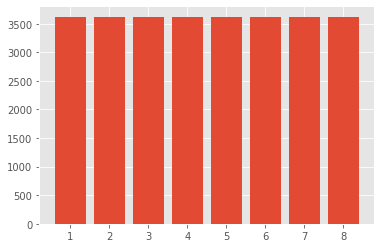

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot

#X, y = train.iloc[:, :-1], train.iloc[:, -1]

# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [ ]:
# K fold stratified lgbm model training
start = time.time()

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1121218)
cv_scores = np.empty(10)

for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    # X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    # y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    X_train, X_test = X[train_idx], X[test_idx]
    

    LGB2 = lgb_model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="multi_error",
            early_stopping_rounds=100
        )
    preds = LGB2.predict(X_test)
    cv_scores[idx] = f1_score(y_test, preds, average='weighted')

stop = time.time()
print(f"Training time : {stop - start}s")

[1]	valid_0's multi_error: 0.615252	valid_0's multi_logloss: 2.0027
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_error: 0.598689	valid_0's multi_logloss: 1.94117
[3]	valid_0's multi_error: 0.590752	valid_0's multi_logloss: 1.89149
[4]	valid_0's multi_error: 0.576605	valid_0's multi_logloss: 1.83588
[5]	valid_0's multi_error: 0.570738	valid_0's multi_logloss: 1.7892
[6]	valid_0's multi_error: 0.573499	valid_0's multi_logloss: 1.74871
[7]	valid_0's multi_error: 0.565908	valid_0's multi_logloss: 1.71402
[8]	valid_0's multi_error: 0.564182	valid_0's multi_logloss: 1.68162
[9]	valid_0's multi_error: 0.563492	valid_0's multi_logloss: 1.65254
[10]	valid_0's multi_error: 0.560732	valid_0's multi_logloss: 1.62561
[11]	valid_0's multi_error: 0.561767	valid_0's multi_logloss: 1.6055
[12]	valid_0's multi_error: 0.560386	valid_0's multi_logloss: 1.58579
[13]	valid_0's multi_error: 0.555901	valid_0's multi_logloss: 1.56664
[14]	valid_0's multi_error: 0.55176	val

In [ ]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(LGB2.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(LGB2.score(X_test, y_test)))


Training set score: 0.5205
Test set score: 0.5085


In [ ]:
# Print the output.
print('List of possible accuracy:', cv_scores)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(cv_scores)*100, '%')
print('\nMinimum Accuracy:',
      min(cv_scores)*100, '%')
print('\nOverall Accuracy:',
      np.mean(cv_scores)*100, '%')
print('\nStandard Deviation is:', np.std(cv_scores))

List of possible accuracy: [0.50847229 0.51668135 0.49239422 0.49693524 0.4995471  0.48889194
 0.48792291 0.5043922  0.51319997 0.5030263 ]

Maximum Accuracy That can be obtained from this model is: 51.66813489175666 %

Minimum Accuracy: 48.79229060909495 %

Overall Accuracy: 50.11463516739021 %

Standard Deviation is: 0.0093610137853587


In [ ]:
! pip install -q scikit-plot

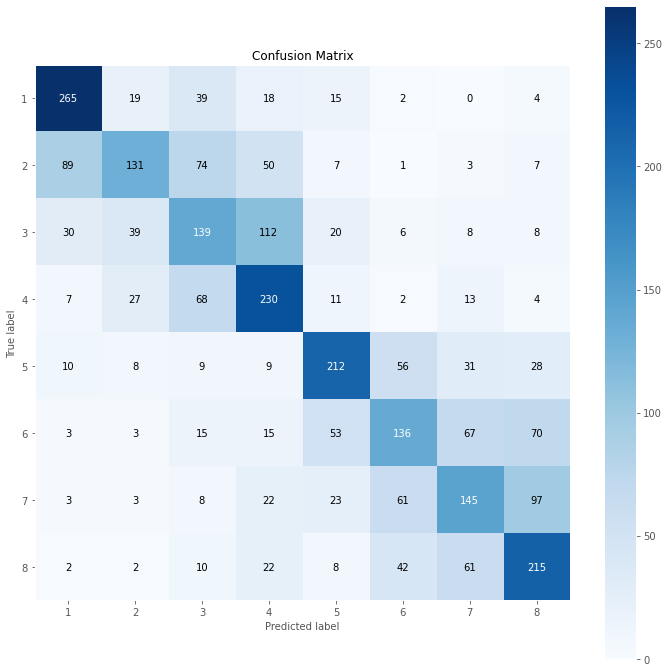

In [ ]:
import scikitplot as skplt

cnf_mat = skplt.metrics.plot_confusion_matrix(
    y_test, 
    preds,
    figsize=(12,12))


In [ ]:
df_test = pd.read_csv("/content/test_data.csv")
t1 = df_test[selected_features[:-1]]
t1.isnull().sum()

age_group                      0
gender                         0
network_stay                   0
average_monthly_bill_amount    0
dusage_sum                     0
dusage_max                     0
dusage_stddev                  0
vusage_offnet_max              0
vusage_offnet_days             0
vusage_offnet_stddev           0
dtype: int64

In [ ]:
test_pred = LGB2.predict(t1)
pred_df = pd.DataFrame(test_pred, columns =['next_month_plan'])

In [ ]:
df_submission = df_test['primary_identifier']
df_submission = pd.concat([df_submission, pred_df], axis=1)
df_submission

,primary_identifier,next_month_plan
0,2003793,1
1,1776101,1
2,6945050,2
3,2472049,1
4,7197266,1
...,...,...
4495,8830679,8
4496,3839728,3
4497,2166141,4
4498,9426198,8


In [ ]:
df_submission.to_csv("submission.csv", encoding='utf-8', index=False)